In [5]:
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib
from sklearn.model_selection import train_test_split


In [3]:
sales = pd.read_csv('data/sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('data/calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('data/sell_prices.csv')
prices.name = 'prices'
validation = pd.read_csv('data/sales_train_validation.csv')
validation.name = 'validation'
print(validation.shape)
validation.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/sales_train_evaluation.csv'

In [ ]:
print(np.unique(sales['d_1936']))
print(sales.shape)
sales.head()

In [4]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [5]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
#         print(i,t)
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

In [6]:
sales = downcast(sales)

In [7]:
prices = downcast(prices)
calendar = downcast(calendar)

In [8]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],\
             var_name='d', value_name='sold').dropna()
#讲day和销售数量转为两列，但是增加了行数
print(df.shape)
df.head()

(60034810, 8)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [9]:
df = pd.merge(df, calendar, on='d', how='left') #和calendar 按照相同索引 d_ 合并
print(df.shape)

(60034810, 21)


In [10]:
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 
#按照 商店 商品和 时间合并 所有数据合并成为一个表
print(df.shape)

(60034810, 22)


In [11]:
#save the categories along with their codes
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [12]:
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [13]:
#类别转成 id
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type_col in enumerate(types):
    if type_col.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes

In [14]:
df.drop('date',axis=1,inplace=True) 
df.head()
# drop the redundant

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,14370,1437,3,1,0,0,1,0,11101,2,...,1,2011,-1,-1,-1,-1,0,0,0,NaN
1,14380,1438,3,1,0,0,1,0,11101,2,...,1,2011,-1,-1,-1,-1,0,0,0,NaN
2,14390,1439,3,1,0,0,1,0,11101,2,...,1,2011,-1,-1,-1,-1,0,0,0,NaN
3,14400,1440,3,1,0,0,1,0,11101,2,...,1,2011,-1,-1,-1,-1,0,0,0,NaN
4,14410,1441,3,1,0,0,1,0,11101,2,...,1,2011,-1,-1,-1,-1,0,0,0,NaN


In [15]:
lags = [1,2,3,6,12,24,36]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']\
                                          ,as_index=False)['sold'].shift(lag).astype(np.float16)
#时间上移位

In [16]:
# 多类别取均值
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

In [17]:
# df['iteam_sold_avg']
# for key,i in df.groupby('item_id')['sold']:
#     print(key,i)
df['sold_lag_6']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
           ... 
60034805    0.0
60034806    0.0
60034807    0.0
60034808    0.0
60034809    0.0
Name: sold_lag_6, Length: 60034810, dtype: float16

In [18]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,...,store_sold_avg,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg
0,14370,1437,3,1,0,0,1,0,11101,2,...,1.304688,0.561035,0.695801,0.695801,0.321533,0.216553,0.216553,1.304688,0.801758,1.020508
1,14380,1438,3,1,0,0,1,0,11101,2,...,1.304688,0.561035,0.695801,0.695801,0.253906,0.259766,0.259766,1.304688,0.801758,1.020508
2,14390,1439,3,1,0,0,1,0,11101,2,...,1.304688,0.561035,0.695801,0.695801,0.156982,0.076660,0.076660,1.304688,0.801758,1.020508
3,14400,1440,3,1,0,0,1,0,11101,2,...,1.304688,0.561035,0.695801,0.695801,1.694336,2.011719,2.011719,1.304688,0.801758,1.020508
4,14410,1441,3,1,0,0,1,0,11101,2,...,1.304688,0.561035,0.695801,0.695801,0.958984,0.755371,0.755371,1.304688,0.801758,1.020508


In [19]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])\
            ['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)
# 周度均值

In [20]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])\
            ['sold'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])\
            ['sold'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)
# 

In [21]:
df = df[df['d']>=36]
# 等价于dropna(any)

In [22]:
df['sold_lag_2']

1067150     0.0
1067151     0.0
1067152     0.0
1067153     0.0
1067154     0.0
           ... 
60034805    0.0
60034806    0.0
60034807    0.0
60034808    0.0
60034809    0.0
Name: sold_lag_2, Length: 58967660, dtype: float16

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58967660 entries, 1067150 to 60034809
Data columns (total 42 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int16  
 1   item_id                   int16  
 2   dept_id                   int8   
 3   cat_id                    int8   
 4   store_id                  int8   
 5   state_id                  int8   
 6   d                         int16  
 7   sold                      int16  
 8   wm_yr_wk                  int16  
 9   weekday                   int8   
 10  wday                      int8   
 11  month                     int8   
 12  year                      int16  
 13  event_name_1              int8   
 14  event_type_1              int8   
 15  event_name_2              int8   
 16  event_type_2              int8   
 17  snap_CA                   int8   
 18  snap_TX                   int8   
 19  snap_WI                   int8   
 20  sell_price      

In [24]:
df.to_pickle('data.pkl')
del df
gc.collect();

In [25]:
data = pd.read_pickle('data.pkl')

# X_test = df[df['d']>=1942]
# X_train, X_valid, y_train, y_valid = train_test_split(df[df['d']<1942], df[df['d']<1942]['sold']\
#                                                       , test_size=0.1, shuffle=True, random_state=54)
# valid = X_valid[['id','d','sold']]
# test = X_test[['id','d','sold']]
# X_valid = X_valid.drop('sold',axis=1)
# X_train = X_train.drop('sold',axis=1)
# X_test = X_test.drop('sold',axis=1)

valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

In [26]:
# np.unique(data['d'])
# dt_dataset
# y_train

In [27]:
#Get the store ids
stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]
    
#     #Split the data
    X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    X_test = df[df['d']>=1942].drop('sold',axis=1)  
        
    #   
#     X_test = df[df['d']>=1942].drop('sold',axis=1)
#     X_train, X_valid, y_train, y_valid = train_test_split(df[df['d']<1942].drop('sold',axis=1), df[df['d']<1942]['sold']\
#                                                           , test_size=0.1, shuffle=True, random_state=54)
    
    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'res/model'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.858887	training's l2: 0.737686	valid_1's rmse: 0.561769	valid_1's l2: 0.315584
[40]	training's rmse: 0.808203	training's l2: 0.653192	valid_1's rmse: 0.540514	valid_1's l2: 0.292156
[60]	training's rmse: 0.784447	training's l2: 0.615357	valid_1's rmse: 0.533795	valid_1's l2: 0.284937
[80]	training's rmse: 0.771881	training's l2: 0.5958	valid_1's rmse: 0.528523	valid_1's l2: 0.279337
[100]	training's rmse: 0.761757	training's l2: 0.580273	valid_1's rmse: 0.527902	valid_1's l2: 0.27868
[120]	training's rmse: 0.74991	training's l2: 0.562366	valid_1's rmse: 0.519742	valid_1's l2: 0.270132
[140]	training's rmse: 0.739869	training's l2: 0.547405	valid_1's rmse: 0.518135	valid_1's l2: 0.268464
[160]	training's rmse: 0.733185	training's l2: 0.53756	valid_1's rmse: 0.514914	valid_1's l2: 0.265137
[180]	training's rmse: 0.724473	training's l2: 0.524861	valid_1's rmse: 0.51059

[20]	training's rmse: 0.801863	training's l2: 0.642985	valid_1's rmse: 0.575957	valid_1's l2: 0.331727
[40]	training's rmse: 0.765318	training's l2: 0.585712	valid_1's rmse: 0.562438	valid_1's l2: 0.316336
[60]	training's rmse: 0.74598	training's l2: 0.556486	valid_1's rmse: 0.567979	valid_1's l2: 0.3226
Early stopping, best iteration is:
[43]	training's rmse: 0.762232	training's l2: 0.580997	valid_1's rmse: 0.56125	valid_1's l2: 0.315001


modelCA_1.pkl
modelCA_2.pkl
modelCA_3.pkl
modelCA_4.pkl
modelTX_1.pkl
modelTX_2.pkl
modelTX_3.pkl
modelWI_1.pkl
modelWI_2.pkl
modelWI_3.pkl


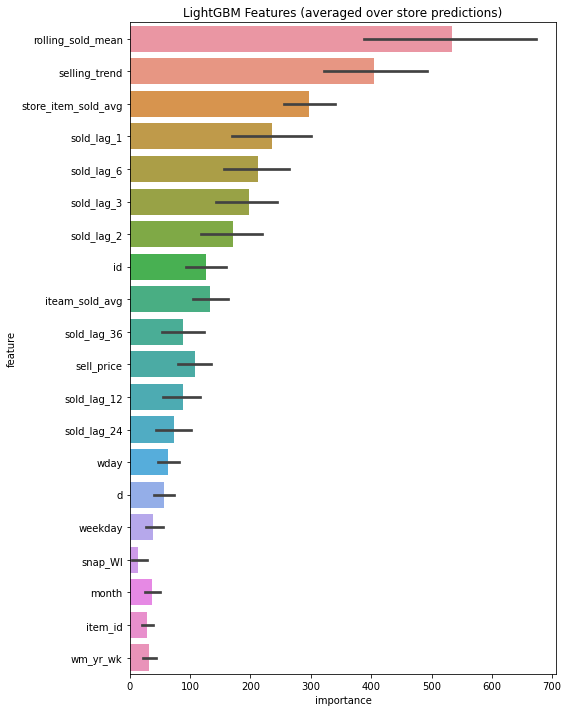

In [28]:
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
for filename in os.listdir('res/'):
    print(filename)
    if 'model' in filename:
        # load model
        model = joblib.load('res/'+filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().\
            sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)
# plot the feature importance

In [29]:
#Set actual equal to false if you want to top in the public leaderboard :P
# actual = False
# if actual == False:
#Get the validation results(We already have them as less than one month left for competition to end)
validation = sales[['id']+['d_' + str(i) for i in range(1914,1942)]]
validation['id']=pd.read_csv('data/sales_train_validation.csv').id
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
# else:
#     #Get the actual validation results
#     print(1)
#     valid['sold'] = valid_preds
#     validation = valid[['id','d','sold']]
#     validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
#     validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#     validation.id = validation.id.map(d_id).str.replace('evaluation','validation')

In [30]:
validation

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,2,0,3,5,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_validation,0,1,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,1,1,0,2,1,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_validation,0,0,1,2,4,1,6,4,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_validation,1,0,2,3,1,0,3,2,3,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0,0,0,2,2,0,0,0,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_validation,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_validation,0,0,1,1,0,2,1,1,0,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_validation,1,3,0,1,2,1,0,2,1,...,1,1,1,4,6,0,1,1,1,0


In [31]:
#Get the evaluation results
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(d_id)

#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('submission.csv',index=False)

In [ ]:
submit.shape